In [156]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # <-- Add this line


# Step 1: Define your base directories
base_dir = r'/kaggle/input/cbis-ddsm-breast-cancer-image-dataset'
jpg_dir = os.path.join(base_dir, 'jpeg')
csv_dir = os.path.join(base_dir, 'csv')

In [157]:
# Step 2: Load your CSV data
df_mass_train = pd.read_csv(os.path.join(csv_dir, 'mass_case_description_train_set.csv'))

df_mass_test = pd.read_csv(os.path.join(csv_dir, 'mass_case_description_test_set.csv'))

In [158]:
# Step 3: Correct the file paths in the DataFrame to point to cropped images
def correct_file_path(row):
    directory = os.path.basename(os.path.dirname(row['cropped image file path']))
    full_dir_path = os.path.join(jpg_dir, directory)
    all_files_in_dir = os.listdir(full_dir_path)
    
    if len(all_files_in_dir) > 0:
        correct_filename = all_files_in_dir[0]
        correct_path = os.path.join(full_dir_path, correct_filename)
    else:
        correct_path = None

    return correct_path

# Apply the corrected path to your DataFrame using the cropped images
df_mass_train['image file path'] = df_mass_train.apply(correct_file_path, axis=1)

In [159]:
# Step 4: Filter out missing files and ensure both CC and MLO views are present
df_mass_filtered = df_mass_train[df_mass_train['image file path'].notnull() & df_mass_train['image file path'].apply(os.path.exists)]

# Ensure both CC and MLO views are present for each patient
df_mass_filtered = df_mass_filtered.groupby('patient_id').filter(lambda x: len(x['image view'].unique()) == 2)

print(f"Remaining files after correction: {len(df_mass_filtered)}")

Remaining files after correction: 1111


In [160]:
# Step 5: Define transformations and create DataLoaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [161]:
df_mass_filtered.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,/kaggle/input/cbis-ddsm-breast-cancer-image-da...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [162]:
df_mass_filtered = df_mass_filtered[['pathology', 'image file path']]
df_mass_filtered.head()

,pathology,image file path
0,MALIGNANT,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
1,MALIGNANT,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
2,BENIGN,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
3,BENIGN,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
4,BENIGN,/kaggle/input/cbis-ddsm-breast-cancer-image-da...


In [163]:
def map_pathology(value):
    if value == 'MALIGNANT':
        return 1
    else:  # 'BENIGN' or 'NORMAL'
        return 0

df_mass_filtered['pathology'] = df_mass_filtered['pathology'].apply(map_pathology)

df_mass_filtered.head()

,pathology,image file path
0,1,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
1,1,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
2,0,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
3,0,/kaggle/input/cbis-ddsm-breast-cancer-image-da...
4,0,/kaggle/input/cbis-ddsm-breast-cancer-image-da...


In [164]:
df_mass_filtered.isnull().sum()

pathology          0
image file path    0
dtype: int64

In [165]:
!pip install imbalanced-learn

import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from transformers import AdamW, SwinForImageClassification, AutoFeatureExtractor
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from collections import Counter
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [166]:
# Split the balanced dataset into training and testing sets
train_df, test_df = train_test_split(df_mass_filtered, test_size=0.2, random_state=42, stratify=df_mass_filtered['pathology'])

In [167]:
from transformers import SwinForImageClassification, AutoFeatureExtractor

# Load the model and feature extractor with the correct number of classes
model = SwinForImageClassification.from_pretrained(
    'microsoft/swin-tiny-patch4-window7-224',
    num_labels=5,  # Set this to the number of classes in your dataset
    ignore_mismatched_sizes=True  # Ignore the size mismatch for the classifier layer
)

feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/swin-tiny-patch4-window7-224')

# Move the model to the correct device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


SwinForImageClassification(
  (swin): SwinModel(
    (embeddings): SwinEmbeddings(
      (patch_embeddings): SwinPatchEmbeddings(
        (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): SwinEncoder(
      (layers): ModuleList(
        (0): SwinStage(
          (blocks): ModuleList(
            (0-1): 2 x SwinLayer(
              (layernorm_before): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attention): SwinAttention(
                (self): SwinSelfAttention(
                  (query): Linear(in_features=96, out_features=96, bias=True)
                  (key): Linear(in_features=96, out_features=96, bias=True)
                  (value): Linear(in_features=96, out_features=96, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )
                (output): SwinSelfOutput(
  

In [168]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [169]:
# Define your dataset class
class MammogramDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image file path']
        image = Image.open(img_path).convert('RGB')
        
        # Use the feature extractor from Hugging Face
        inputs = feature_extractor(images=image, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)  # Remove the batch dimension
        
        label = self.dataframe.iloc[idx]['pathology']
        
        return pixel_values, label

In [170]:
# Create DataLoaders
train_dataset = MammogramDataset(dataframe=train_df)
test_dataset = MammogramDataset(dataframe=test_df)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [171]:
import torch.nn as nn

# Set up the optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=0.00001, weight_decay=0.0001)
#scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/15, Batch 1/28, Batch Loss: 1.8505369424819946
Epoch 1/15, Batch 2/28, Batch Loss: 1.779377818107605
Epoch 1/15, Batch 3/28, Batch Loss: 1.734642505645752
Epoch 1/15, Batch 4/28, Batch Loss: 1.605952501296997
Epoch 1/15, Batch 5/28, Batch Loss: 1.542777419090271
Epoch 1/15, Batch 6/28, Batch Loss: 1.551614761352539
Epoch 1/15, Batch 7/28, Batch Loss: 1.4590740203857422
Epoch 1/15, Batch 8/28, Batch Loss: 1.3718581199645996
Epoch 1/15, Batch 9/28, Batch Loss: 1.3264487981796265
Epoch 1/15, Batch 10/28, Batch Loss: 1.2644879817962646
Epoch 1/15, Batch 11/28, Batch Loss: 1.1945219039916992
Epoch 1/15, Batch 12/28, Batch Loss: 1.26402747631073
Epoch 1/15, Batch 13/28, Batch Loss: 1.1285432577133179
Epoch 1/15, Batch 14/28, Batch Loss: 1.2184631824493408
Epoch 1/15, Batch 15/28, Batch Loss: 1.1702724695205688
Epoch 1/15, Batch 16/28, Batch Loss: 1.2182680368423462
Epoch 1/15, Batch 17/28, Batch Loss: 1.11885666847229
Epoch 1/15, Batch 18/28, Batch Loss: 1.0750837326049805
Epoch 1/15

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/15, Batch 28/28, Batch Loss: 0.8411862254142761
Epoch 1/15 Completed. Avg Loss: 1.2206279337406158, Accuracy: 0.43018018018018017


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.9123469591140747, Validation Accuracy: 0.5919282511210763


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/15, Batch 1/28, Batch Loss: 0.7979674935340881
Epoch 2/15, Batch 2/28, Batch Loss: 0.7761421203613281
Epoch 2/15, Batch 3/28, Batch Loss: 0.7660534977912903
Epoch 2/15, Batch 4/28, Batch Loss: 0.7660115361213684
Epoch 2/15, Batch 5/28, Batch Loss: 0.7930134534835815
Epoch 2/15, Batch 6/28, Batch Loss: 0.7915742993354797
Epoch 2/15, Batch 7/28, Batch Loss: 0.82863450050354
Epoch 2/15, Batch 8/28, Batch Loss: 0.7265001535415649
Epoch 2/15, Batch 9/28, Batch Loss: 0.707434892654419
Epoch 2/15, Batch 10/28, Batch Loss: 0.7308721542358398
Epoch 2/15, Batch 11/28, Batch Loss: 0.7503552436828613
Epoch 2/15, Batch 12/28, Batch Loss: 0.762855589389801
Epoch 2/15, Batch 13/28, Batch Loss: 0.6557191610336304
Epoch 2/15, Batch 14/28, Batch Loss: 0.7321749329566956
Epoch 2/15, Batch 15/28, Batch Loss: 0.6570330858230591
Epoch 2/15, Batch 16/28, Batch Loss: 0.6743678450584412
Epoch 2/15, Batch 17/28, Batch Loss: 0.7873952388763428
Epoch 2/15, Batch 18/28, Batch Loss: 0.6721873879432678
Epoch

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 2/15, Batch 28/28, Batch Loss: 0.7026665210723877
Epoch 2/15 Completed. Avg Loss: 0.725964510015079, Accuracy: 0.581081081081081


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.7191940035138812, Validation Accuracy: 0.6322869955156951


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/15, Batch 1/28, Batch Loss: 0.7074098587036133
Epoch 3/15, Batch 2/28, Batch Loss: 0.7648071050643921
Epoch 3/15, Batch 3/28, Batch Loss: 0.5468525290489197
Epoch 3/15, Batch 4/28, Batch Loss: 0.6405649781227112
Epoch 3/15, Batch 5/28, Batch Loss: 0.5934931635856628
Epoch 3/15, Batch 6/28, Batch Loss: 0.6425566077232361
Epoch 3/15, Batch 7/28, Batch Loss: 0.6931659579277039
Epoch 3/15, Batch 8/28, Batch Loss: 0.6740604639053345
Epoch 3/15, Batch 9/28, Batch Loss: 0.7163903713226318
Epoch 3/15, Batch 10/28, Batch Loss: 0.6233468651771545
Epoch 3/15, Batch 11/28, Batch Loss: 0.5966167449951172
Epoch 3/15, Batch 12/28, Batch Loss: 0.6538870930671692
Epoch 3/15, Batch 13/28, Batch Loss: 0.584358274936676
Epoch 3/15, Batch 14/28, Batch Loss: 0.706106424331665
Epoch 3/15, Batch 15/28, Batch Loss: 0.6227242946624756
Epoch 3/15, Batch 16/28, Batch Loss: 0.6397498846054077
Epoch 3/15, Batch 17/28, Batch Loss: 0.6789509057998657
Epoch 3/15, Batch 18/28, Batch Loss: 0.678238034248352
Epoc

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 3/15, Batch 28/28, Batch Loss: 0.7306063175201416
Epoch 3/15 Completed. Avg Loss: 0.6535213142633438, Accuracy: 0.6407657657657657


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6542737228529794, Validation Accuracy: 0.6591928251121076


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/15, Batch 1/28, Batch Loss: 0.6241607666015625
Epoch 4/15, Batch 2/28, Batch Loss: 0.5410786867141724
Epoch 4/15, Batch 3/28, Batch Loss: 0.5606920719146729
Epoch 4/15, Batch 4/28, Batch Loss: 0.5870910882949829
Epoch 4/15, Batch 5/28, Batch Loss: 0.5860565900802612
Epoch 4/15, Batch 6/28, Batch Loss: 0.6399115324020386
Epoch 4/15, Batch 7/28, Batch Loss: 0.5962506532669067
Epoch 4/15, Batch 8/28, Batch Loss: 0.46924200654029846
Epoch 4/15, Batch 9/28, Batch Loss: 0.620963454246521
Epoch 4/15, Batch 10/28, Batch Loss: 0.6456443071365356
Epoch 4/15, Batch 11/28, Batch Loss: 0.8153167366981506
Epoch 4/15, Batch 12/28, Batch Loss: 0.5976402759552002
Epoch 4/15, Batch 13/28, Batch Loss: 0.5668129324913025
Epoch 4/15, Batch 14/28, Batch Loss: 0.581869900226593
Epoch 4/15, Batch 15/28, Batch Loss: 0.6562610268592834
Epoch 4/15, Batch 16/28, Batch Loss: 0.5440755486488342
Epoch 4/15, Batch 17/28, Batch Loss: 0.6968145966529846
Epoch 4/15, Batch 18/28, Batch Loss: 0.5436283946037292
Ep

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 4/15, Batch 28/28, Batch Loss: 0.6261636018753052
Epoch 4/15 Completed. Avg Loss: 0.6089185082486698, Accuracy: 0.6779279279279279


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6278228334018162, Validation Accuracy: 0.6502242152466368


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/15, Batch 1/28, Batch Loss: 0.6437867879867554
Epoch 5/15, Batch 2/28, Batch Loss: 0.6045448780059814
Epoch 5/15, Batch 3/28, Batch Loss: 0.5901139378547668
Epoch 5/15, Batch 4/28, Batch Loss: 0.5934237241744995
Epoch 5/15, Batch 5/28, Batch Loss: 0.5733844041824341
Epoch 5/15, Batch 6/28, Batch Loss: 0.5104766488075256
Epoch 5/15, Batch 7/28, Batch Loss: 0.5049419403076172
Epoch 5/15, Batch 8/28, Batch Loss: 0.5908045768737793
Epoch 5/15, Batch 9/28, Batch Loss: 0.6032150983810425
Epoch 5/15, Batch 10/28, Batch Loss: 0.5564814805984497
Epoch 5/15, Batch 11/28, Batch Loss: 0.5540471076965332
Epoch 5/15, Batch 12/28, Batch Loss: 0.6550392508506775
Epoch 5/15, Batch 13/28, Batch Loss: 0.5725881457328796
Epoch 5/15, Batch 14/28, Batch Loss: 0.5702472925186157
Epoch 5/15, Batch 15/28, Batch Loss: 0.4948011636734009
Epoch 5/15, Batch 16/28, Batch Loss: 0.6303032636642456
Epoch 5/15, Batch 17/28, Batch Loss: 0.5724536776542664
Epoch 5/15, Batch 18/28, Batch Loss: 0.5326525568962097
E

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 5/15, Batch 28/28, Batch Loss: 0.4617275297641754
Epoch 5/15 Completed. Avg Loss: 0.572603162910257, Accuracy: 0.6903153153153153


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6271693110466003, Validation Accuracy: 0.6412556053811659


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/15, Batch 1/28, Batch Loss: 0.7009024024009705
Epoch 6/15, Batch 2/28, Batch Loss: 0.6001378297805786
Epoch 6/15, Batch 3/28, Batch Loss: 0.5368891954421997
Epoch 6/15, Batch 4/28, Batch Loss: 0.5033797025680542
Epoch 6/15, Batch 5/28, Batch Loss: 0.5022048950195312
Epoch 6/15, Batch 6/28, Batch Loss: 0.43679216504096985
Epoch 6/15, Batch 7/28, Batch Loss: 0.6149266362190247
Epoch 6/15, Batch 8/28, Batch Loss: 0.7448617219924927
Epoch 6/15, Batch 9/28, Batch Loss: 0.4843842685222626
Epoch 6/15, Batch 10/28, Batch Loss: 0.5036234855651855
Epoch 6/15, Batch 11/28, Batch Loss: 0.6359472870826721
Epoch 6/15, Batch 12/28, Batch Loss: 0.711061954498291
Epoch 6/15, Batch 13/28, Batch Loss: 0.7189476490020752
Epoch 6/15, Batch 14/28, Batch Loss: 0.5583018660545349
Epoch 6/15, Batch 15/28, Batch Loss: 0.7183693051338196
Epoch 6/15, Batch 16/28, Batch Loss: 0.4461441934108734
Epoch 6/15, Batch 17/28, Batch Loss: 0.5442851185798645
Epoch 6/15, Batch 18/28, Batch Loss: 0.5445964932441711
E

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 6/15, Batch 28/28, Batch Loss: 0.6089358925819397
Epoch 6/15 Completed. Avg Loss: 0.5678809402244431, Accuracy: 0.7038288288288288


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.5901745387486049, Validation Accuracy: 0.6278026905829597


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/15, Batch 1/28, Batch Loss: 0.5121734738349915
Epoch 7/15, Batch 2/28, Batch Loss: 0.4646170437335968
Epoch 7/15, Batch 3/28, Batch Loss: 0.5265007019042969
Epoch 7/15, Batch 4/28, Batch Loss: 0.6236554980278015
Epoch 7/15, Batch 5/28, Batch Loss: 0.4697498381137848
Epoch 7/15, Batch 6/28, Batch Loss: 0.5737866163253784
Epoch 7/15, Batch 7/28, Batch Loss: 0.43792518973350525
Epoch 7/15, Batch 8/28, Batch Loss: 0.6561381220817566
Epoch 7/15, Batch 9/28, Batch Loss: 0.5914949178695679
Epoch 7/15, Batch 10/28, Batch Loss: 0.6002128720283508
Epoch 7/15, Batch 11/28, Batch Loss: 0.5874269604682922
Epoch 7/15, Batch 12/28, Batch Loss: 0.5451093316078186
Epoch 7/15, Batch 13/28, Batch Loss: 0.6233031749725342
Epoch 7/15, Batch 14/28, Batch Loss: 0.534946858882904
Epoch 7/15, Batch 15/28, Batch Loss: 0.7464613914489746
Epoch 7/15, Batch 16/28, Batch Loss: 0.4119928777217865
Epoch 7/15, Batch 17/28, Batch Loss: 0.46559616923332214
Epoch 7/15, Batch 18/28, Batch Loss: 0.5163428783416748


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 7/15, Batch 28/28, Batch Loss: 0.5731286406517029
Epoch 7/15 Completed. Avg Loss: 0.5393102296761104, Accuracy: 0.7105855855855856


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6216661206313542, Validation Accuracy: 0.6681614349775785


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/15, Batch 1/28, Batch Loss: 0.49126341938972473
Epoch 8/15, Batch 2/28, Batch Loss: 0.6254616975784302
Epoch 8/15, Batch 3/28, Batch Loss: 0.4645559787750244
Epoch 8/15, Batch 4/28, Batch Loss: 0.48073291778564453
Epoch 8/15, Batch 5/28, Batch Loss: 0.5341500043869019
Epoch 8/15, Batch 6/28, Batch Loss: 0.46886956691741943
Epoch 8/15, Batch 7/28, Batch Loss: 0.4770098030567169
Epoch 8/15, Batch 8/28, Batch Loss: 0.4905121922492981
Epoch 8/15, Batch 9/28, Batch Loss: 0.35770848393440247
Epoch 8/15, Batch 10/28, Batch Loss: 0.4798232316970825
Epoch 8/15, Batch 11/28, Batch Loss: 0.673828125
Epoch 8/15, Batch 12/28, Batch Loss: 0.595479428768158
Epoch 8/15, Batch 13/28, Batch Loss: 0.4112047255039215
Epoch 8/15, Batch 14/28, Batch Loss: 0.514461100101471
Epoch 8/15, Batch 15/28, Batch Loss: 0.46797674894332886
Epoch 8/15, Batch 16/28, Batch Loss: 0.5586201548576355
Epoch 8/15, Batch 17/28, Batch Loss: 0.5103318095207214
Epoch 8/15, Batch 18/28, Batch Loss: 0.4690060615539551
Epoch

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 8/15, Batch 28/28, Batch Loss: 0.45087873935699463
Epoch 8/15 Completed. Avg Loss: 0.49230516276189257, Accuracy: 0.7668918918918919


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6341343181473869, Validation Accuracy: 0.6636771300448431


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/15, Batch 1/28, Batch Loss: 0.5389537811279297
Epoch 9/15, Batch 2/28, Batch Loss: 0.4660148620605469
Epoch 9/15, Batch 3/28, Batch Loss: 0.5541027784347534
Epoch 9/15, Batch 4/28, Batch Loss: 0.32161229848861694
Epoch 9/15, Batch 5/28, Batch Loss: 0.5904035568237305
Epoch 9/15, Batch 6/28, Batch Loss: 0.36853960156440735
Epoch 9/15, Batch 7/28, Batch Loss: 0.5015477538108826
Epoch 9/15, Batch 8/28, Batch Loss: 0.5168617963790894
Epoch 9/15, Batch 9/28, Batch Loss: 0.5035066604614258
Epoch 9/15, Batch 10/28, Batch Loss: 0.41249996423721313
Epoch 9/15, Batch 11/28, Batch Loss: 0.41807225346565247
Epoch 9/15, Batch 12/28, Batch Loss: 0.3742929995059967
Epoch 9/15, Batch 13/28, Batch Loss: 0.44287019968032837
Epoch 9/15, Batch 14/28, Batch Loss: 0.39257559180259705
Epoch 9/15, Batch 15/28, Batch Loss: 0.8421163558959961
Epoch 9/15, Batch 16/28, Batch Loss: 0.38841712474823
Epoch 9/15, Batch 17/28, Batch Loss: 0.4500945210456848
Epoch 9/15, Batch 18/28, Batch Loss: 0.37501248717308

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 9/15, Batch 28/28, Batch Loss: 0.39344409108161926
Epoch 9/15 Completed. Avg Loss: 0.4829181006976536, Accuracy: 0.7635135135135135


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6310890913009644, Validation Accuracy: 0.6591928251121076


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/15, Batch 1/28, Batch Loss: 0.532694399356842
Epoch 10/15, Batch 2/28, Batch Loss: 0.4752044975757599
Epoch 10/15, Batch 3/28, Batch Loss: 0.43886154890060425
Epoch 10/15, Batch 4/28, Batch Loss: 0.40100157260894775
Epoch 10/15, Batch 5/28, Batch Loss: 0.5472531318664551
Epoch 10/15, Batch 6/28, Batch Loss: 0.5104647874832153
Epoch 10/15, Batch 7/28, Batch Loss: 0.39258262515068054
Epoch 10/15, Batch 8/28, Batch Loss: 0.4050670266151428
Epoch 10/15, Batch 9/28, Batch Loss: 0.4478701055049896
Epoch 10/15, Batch 10/28, Batch Loss: 0.4831579923629761
Epoch 10/15, Batch 11/28, Batch Loss: 0.5581606030464172
Epoch 10/15, Batch 12/28, Batch Loss: 0.4302235245704651
Epoch 10/15, Batch 13/28, Batch Loss: 0.43410083651542664
Epoch 10/15, Batch 14/28, Batch Loss: 0.45495840907096863
Epoch 10/15, Batch 15/28, Batch Loss: 0.3947286605834961
Epoch 10/15, Batch 16/28, Batch Loss: 0.3739427924156189
Epoch 10/15, Batch 17/28, Batch Loss: 0.4786336123943329
Epoch 10/15, Batch 18/28, Batch Loss

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 10/15, Batch 28/28, Batch Loss: 0.42523136734962463
Epoch 10/15 Completed. Avg Loss: 0.4524293520620891, Accuracy: 0.7804054054054054


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6129352961267743, Validation Accuracy: 0.6636771300448431


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/15, Batch 1/28, Batch Loss: 0.5447290539741516
Epoch 11/15, Batch 2/28, Batch Loss: 0.3954036831855774
Epoch 11/15, Batch 3/28, Batch Loss: 0.43505120277404785
Epoch 11/15, Batch 4/28, Batch Loss: 0.4016425311565399
Epoch 11/15, Batch 5/28, Batch Loss: 0.5475441217422485
Epoch 11/15, Batch 6/28, Batch Loss: 0.4456392824649811
Epoch 11/15, Batch 7/28, Batch Loss: 0.4922400712966919
Epoch 11/15, Batch 8/28, Batch Loss: 0.4546157419681549
Epoch 11/15, Batch 9/28, Batch Loss: 0.4222845435142517
Epoch 11/15, Batch 10/28, Batch Loss: 0.4494136571884155
Epoch 11/15, Batch 11/28, Batch Loss: 0.5805004835128784
Epoch 11/15, Batch 12/28, Batch Loss: 0.4549252390861511
Epoch 11/15, Batch 13/28, Batch Loss: 0.29408174753189087
Epoch 11/15, Batch 14/28, Batch Loss: 0.3077032268047333
Epoch 11/15, Batch 15/28, Batch Loss: 0.41991424560546875
Epoch 11/15, Batch 16/28, Batch Loss: 0.39040908217430115
Epoch 11/15, Batch 17/28, Batch Loss: 0.5491511225700378
Epoch 11/15, Batch 18/28, Batch Loss

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 11/15, Batch 28/28, Batch Loss: 0.4364393651485443
Epoch 11/15 Completed. Avg Loss: 0.43391155132225584, Accuracy: 0.795045045045045


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6625918320247105, Validation Accuracy: 0.6591928251121076


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/15, Batch 1/28, Batch Loss: 0.36444056034088135
Epoch 12/15, Batch 2/28, Batch Loss: 0.3097251057624817
Epoch 12/15, Batch 3/28, Batch Loss: 0.5034767389297485
Epoch 12/15, Batch 4/28, Batch Loss: 0.34334030747413635
Epoch 12/15, Batch 5/28, Batch Loss: 0.40431445837020874
Epoch 12/15, Batch 6/28, Batch Loss: 0.4193118214607239
Epoch 12/15, Batch 7/28, Batch Loss: 0.42754068970680237
Epoch 12/15, Batch 8/28, Batch Loss: 0.5234866738319397
Epoch 12/15, Batch 9/28, Batch Loss: 0.32748931646347046
Epoch 12/15, Batch 10/28, Batch Loss: 0.6039069890975952
Epoch 12/15, Batch 11/28, Batch Loss: 0.4288331866264343
Epoch 12/15, Batch 12/28, Batch Loss: 0.6326925754547119
Epoch 12/15, Batch 13/28, Batch Loss: 0.455560564994812
Epoch 12/15, Batch 14/28, Batch Loss: 0.3357754349708557
Epoch 12/15, Batch 15/28, Batch Loss: 0.31290096044540405
Epoch 12/15, Batch 16/28, Batch Loss: 0.5104911923408508
Epoch 12/15, Batch 17/28, Batch Loss: 0.40407681465148926
Epoch 12/15, Batch 18/28, Batch Lo

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 12/15, Batch 28/28, Batch Loss: 0.4321884214878082
Epoch 12/15 Completed. Avg Loss: 0.4254116096666881, Accuracy: 0.7871621621621622


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.632034991468702, Validation Accuracy: 0.6860986547085202


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/15, Batch 1/28, Batch Loss: 0.3773978054523468
Epoch 13/15, Batch 2/28, Batch Loss: 0.42276763916015625
Epoch 13/15, Batch 3/28, Batch Loss: 0.2256573736667633
Epoch 13/15, Batch 4/28, Batch Loss: 0.42349112033843994
Epoch 13/15, Batch 5/28, Batch Loss: 0.44302502274513245
Epoch 13/15, Batch 6/28, Batch Loss: 0.4390339255332947
Epoch 13/15, Batch 7/28, Batch Loss: 0.33315566182136536
Epoch 13/15, Batch 8/28, Batch Loss: 0.32747986912727356
Epoch 13/15, Batch 9/28, Batch Loss: 0.3173031508922577
Epoch 13/15, Batch 10/28, Batch Loss: 0.4964861273765564
Epoch 13/15, Batch 11/28, Batch Loss: 0.4227132201194763
Epoch 13/15, Batch 12/28, Batch Loss: 0.46177712082862854
Epoch 13/15, Batch 13/28, Batch Loss: 0.36989519000053406
Epoch 13/15, Batch 14/28, Batch Loss: 0.3526015281677246
Epoch 13/15, Batch 15/28, Batch Loss: 0.2696300148963928
Epoch 13/15, Batch 16/28, Batch Loss: 0.4075588583946228
Epoch 13/15, Batch 17/28, Batch Loss: 0.3624778091907501
Epoch 13/15, Batch 18/28, Batch L

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 13/15, Batch 28/28, Batch Loss: 0.28136539459228516
Epoch 13/15 Completed. Avg Loss: 0.3878820911049843, Accuracy: 0.8153153153153153


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6291083480630603, Validation Accuracy: 0.695067264573991


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/15, Batch 1/28, Batch Loss: 0.37238091230392456
Epoch 14/15, Batch 2/28, Batch Loss: 0.2626560926437378
Epoch 14/15, Batch 3/28, Batch Loss: 0.37562239170074463
Epoch 14/15, Batch 4/28, Batch Loss: 0.35808607935905457
Epoch 14/15, Batch 5/28, Batch Loss: 0.35948681831359863
Epoch 14/15, Batch 6/28, Batch Loss: 0.4988684058189392
Epoch 14/15, Batch 7/28, Batch Loss: 0.33457738161087036
Epoch 14/15, Batch 8/28, Batch Loss: 0.3777986168861389
Epoch 14/15, Batch 9/28, Batch Loss: 0.3357410132884979
Epoch 14/15, Batch 10/28, Batch Loss: 0.3953871428966522
Epoch 14/15, Batch 11/28, Batch Loss: 0.43264228105545044
Epoch 14/15, Batch 12/28, Batch Loss: 0.5228512287139893
Epoch 14/15, Batch 13/28, Batch Loss: 0.411244660615921
Epoch 14/15, Batch 14/28, Batch Loss: 0.33923864364624023
Epoch 14/15, Batch 15/28, Batch Loss: 0.29402440786361694
Epoch 14/15, Batch 16/28, Batch Loss: 0.3783973753452301
Epoch 14/15, Batch 17/28, Batch Loss: 0.37921038269996643
Epoch 14/15, Batch 18/28, Batch 

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 14/15, Batch 28/28, Batch Loss: 0.3667804002761841
Epoch 14/15 Completed. Avg Loss: 0.37006951815315653, Accuracy: 0.8378378378378378


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6276775598526001, Validation Accuracy: 0.6860986547085202


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/15, Batch 1/28, Batch Loss: 0.41939109563827515
Epoch 15/15, Batch 2/28, Batch Loss: 0.3423362970352173
Epoch 15/15, Batch 3/28, Batch Loss: 0.40499502420425415
Epoch 15/15, Batch 4/28, Batch Loss: 0.40520891547203064
Epoch 15/15, Batch 5/28, Batch Loss: 0.4089978337287903
Epoch 15/15, Batch 6/28, Batch Loss: 0.3947133421897888
Epoch 15/15, Batch 7/28, Batch Loss: 0.4625316262245178
Epoch 15/15, Batch 8/28, Batch Loss: 0.3567792773246765
Epoch 15/15, Batch 9/28, Batch Loss: 0.35088902711868286
Epoch 15/15, Batch 10/28, Batch Loss: 0.35466232895851135
Epoch 15/15, Batch 11/28, Batch Loss: 0.33290404081344604
Epoch 15/15, Batch 12/28, Batch Loss: 0.35808974504470825
Epoch 15/15, Batch 13/28, Batch Loss: 0.30800020694732666
Epoch 15/15, Batch 14/28, Batch Loss: 0.32871949672698975
Epoch 15/15, Batch 15/28, Batch Loss: 0.25002703070640564
Epoch 15/15, Batch 16/28, Batch Loss: 0.3933100700378418
Epoch 15/15, Batch 17/28, Batch Loss: 0.35949504375457764
Epoch 15/15, Batch 18/28, Bat

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 15/15 Completed. Avg Loss: 0.3618531546422413, Accuracy: 0.8412162162162162


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 0.6303958339350564, Validation Accuracy: 0.6860986547085202
Training complete.


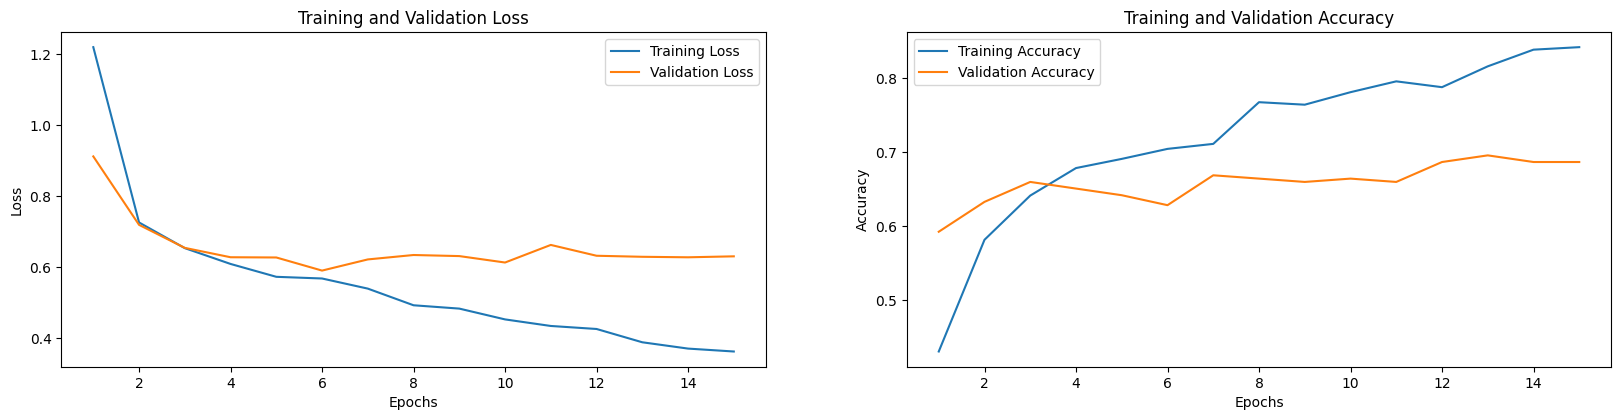

Confusion Matrix:
          FP  TP  FN  TN
Class 0  31  75  39  78
Class 1  39  78  31  75


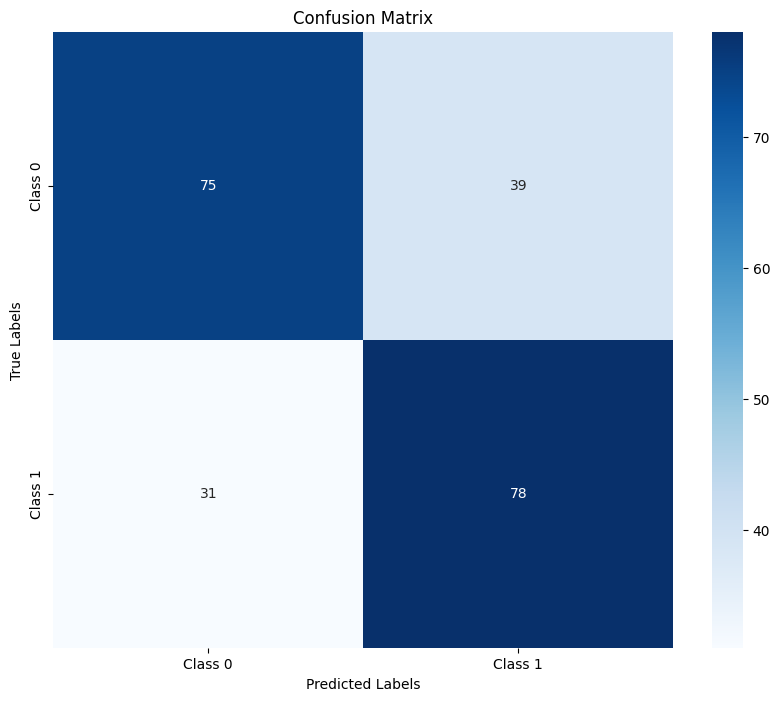

In [172]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

# Initialize lists to store training and validation metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize lists to store precision, recall, and f1-score for each class
train_precisions = []
train_recalls = []
train_f1_scores = []
val_precisions = []
val_recalls = []
val_f1_scores = []

# Training and validation loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(pixel_values=images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

        # Print batch loss
        print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_dataloader)}, Batch Loss: {loss.item()}")

    # Calculate training metrics
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_losses.append(running_loss / len(train_dataloader))
    train_accuracies.append(train_accuracy)
    
    train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)

    print(f"Epoch {epoch+1}/{num_epochs} Completed. Avg Loss: {running_loss/len(train_dataloader)}, Accuracy: {train_accuracy}")
    
    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    all_val_labels = []
    all_val_preds = []
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(pixel_values=images).logits
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(preds.cpu().numpy())

    val_accuracy = accuracy_score(all_val_labels, all_val_preds)
    val_losses.append(val_running_loss / len(test_dataloader))
    val_accuracies.append(val_accuracy)

    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(all_val_labels, all_val_preds, average=None)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1)
    
    print(f"Validation Loss: {val_running_loss/len(test_dataloader)}, Validation Accuracy: {val_accuracy}")
    
    scheduler.step(val_running_loss / len(test_dataloader))

print("Training complete.")


# Plotting Training and Validation Loss
plt.figure(figsize=(20, 20))

plt.subplot(4, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(4, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

num_classes = len(train_precisions[0])

plt.show()

# Calculate and plot confusion matrix for the last epoch
cm = confusion_matrix(all_val_labels, all_val_preds)

# Compute FP, TP, FN, TN
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Create DataFrame for better visualization
confusion_df = pd.DataFrame({
    'FP': FP,
    'TP': TP,
    'FN': FN,
    'TN': TN
}, index=[f'Class {i}' for i in range(len(FP))])

print("Confusion Matrix:\n", confusion_df)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i}' for i in range(len(cm))],
            yticklabels=[f'Class {i}' for i in range(len(cm))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()